In [ ]:
#avoids the need for users to install TD2C as a package
import sys
sys.path.append('../../') 

In [3]:
import os
import sys
import time
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier

# --- Environment Setup for Fair Benchmarking ---
# This is crucial for methods like VARLiNGAM that might use multiple threads
# even when n_jobs is not explicitly set high.
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# --- Import D2C and Benchmark Classes ---
from src.td2c.data_generation.builder import TSBuilder
from src.td2c.descriptors import DataLoader
from src.td2c.benchmark import VAR, VARLiNGAM, PCMCI, Granger, DYNOTEARS, MultivariateGranger,D2CWrapper
from imblearn.ensemble import BalancedRandomForestClassifier


In [26]:

# --- Configuration ---
N_VARS_LIST = [3, 5, 10, 15, 20, 25]
MAXLAGS = 3
N_JOBS_D2C_LOW = 1
N_JOBS_D2C_HIGH = 50 # As requested
TRAINING_DESCRIPTORS_PATH = 'data/descriptors_df_train.pkl'
RESULTS_SAVE_PATH = 'data/benchmark_times_by_nvars.csv'


In [16]:
def train_model(path_to_descriptors: str):
    """
    Loads training descriptors and trains a BalancedRandomForestClassifier.
    """
    print(f"Loading training data from {path_to_descriptors}...")
    try:
        descriptors_df_train = pd.read_pickle(path_to_descriptors)
    except FileNotFoundError:
        print(f"ERROR: Training data not found at {path_to_descriptors}.")
        print("Please ensure you have generated and saved the training descriptors.")
        sys.exit(1)

    print("Training the classifier...")
    X_train = descriptors_df_train.drop(columns=['graph_id', 'edge_source', 'edge_dest', 'is_causal'])
    y_train = descriptors_df_train['is_causal']

    # Using the same classifier as in the notebook for consistency
    clf = BalancedRandomForestClassifier(
        n_estimators=500,
        class_weight='balanced',
        random_state=42,
        replacement=True,
        bootstrap=True,
        sampling_strategy='all',
        n_jobs=1
    )
    clf.fit(X_train, y_train)
    print("Classifier training complete.")
    return clf


In [27]:

# --- Main Benchmark Execution ---
def run_benchmark(model):
    """
    Runs the full benchmark across different numbers of variables and processes.
    """
    results_list = []

    # Define the set of standard benchmark methods to run
    benchmark_methods = {
        'VAR': VAR,
        'VARLiNGAM': VARLiNGAM,
        'Granger': Granger,
        'DYNOTEARS': DYNOTEARS,
        'MultivariateGranger': MultivariateGranger
    }

    for n_vars in N_VARS_LIST:
        print("\n" + "="*60)
        print(f"Benchmarking: {n_vars} variables, Process ID")
        print("="*60)

        # --- 2. Generate a single time series for the current configuration ---
        print("Generating time series data...")
        tsbuilder = TSBuilder(
            observations_per_time_series=250,
            maxlags=MAXLAGS,
            n_variables=n_vars,
            time_series_per_process=1,
            processes_to_use=[2],
            noise_dist='gaussian',
            noise_scale=0.1,
            max_neighborhood_size=2,
            seed=42,
            max_attempts=10,
            verbose=False # Keep output clean
        )
        tsbuilder.build()

        # Use DataLoader to easily get original and lagged data formats
        dataloader = DataLoader(n_variables=n_vars, maxlags=MAXLAGS)
        dataloader.from_tsbuilder(tsbuilder)
        
        # The methods expect a list of time series, which DataLoader provides
        original_observations_list = dataloader.get_original_observations()
        lagged_observations_list = dataloader.get_observations()

        # --- 3. Run standard benchmarks (n_jobs=1) ---
        for name, method_class in benchmark_methods.items():
            print(f"Running {name}...")
            start_time = time.time()
            try:
                runner = method_class(
                    ts_list=original_observations_list,
                    maxlags=MAXLAGS,
                    n_jobs=1 # Critical for fair comparison
                )
                runner.run()
            except Exception as e:
                print(f"  ERROR running {name}: {e}")
                # You might want to log the error and continue
            
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"  {name} finished in {execution_time:.4f} seconds.")
            results_list.append({
                'n_variables': n_vars,
                'method': name,
                'execution_time': execution_time
            })

        # Run PCMCI with ParCorr (the default)
        method_name_pcmci_default = 'PCMCI (ParCorr)'
        print(f"Running {method_name_pcmci_default}...")
        start_time = time.time()
        try:
            runner_pcmci_default = PCMCI(
                ts_list=original_observations_list,
                maxlags=MAXLAGS,
                n_jobs=1,
                ci='ParCorr' # Explicitly state the default for clarity
            )
            runner_pcmci_default.run()
        except Exception as e:
            print(f"  ERROR running {method_name_pcmci_default}: {e}")
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"  {method_name_pcmci_default} finished in {execution_time:.4f} seconds.")
        results_list.append({
            'n_variables': n_vars,
            'method': method_name_pcmci_default,
            'execution_time': execution_time
        })

        # Run PCMCI with GPDC
        method_name_pcmci_gpdc = 'PCMCI (GPDC)'
        print(f"Running {method_name_pcmci_gpdc}...")
        start_time = time.time()
        try:
            runner_pcmci_gpdc = PCMCI(
                ts_list=original_observations_list,
                maxlags=MAXLAGS,
                n_jobs=1,
                ci='GPDC' # Use the specified conditional independence test
            )
            runner_pcmci_gpdc.run()
        except Exception as e:
            print(f"  ERROR running {method_name_pcmci_gpdc}: {e}")
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"  {method_name_pcmci_gpdc} finished in {execution_time:.4f} seconds.")
        results_list.append({
            'n_variables': n_vars,
            'method': method_name_pcmci_gpdc,
            'execution_time': execution_time
        })


        # --- 4. Run D2CWrapper with different n_jobs settings ---
        # D2C (1 job)
        method_name_d2c_low = f'D2C ({N_JOBS_D2C_LOW} job)'
        print(f"Running {method_name_d2c_low}...")
        start_time = time.time()
        d2c_runner_low = D2CWrapper(
            ts_list=lagged_observations_list,
            model=model,
            n_variables=n_vars,
            maxlags=MAXLAGS,
            mb_estimator='ts',
            n_jobs=N_JOBS_D2C_LOW,
            full=True,
            dynamic=True,
            manages_own_parallelism=True # Times internal parallelism
        )
        d2c_runner_low.run()
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"  {method_name_d2c_low} finished in {execution_time:.4f} seconds.")
        results_list.append({
            'n_variables': n_vars,
            'method': method_name_d2c_low,
            'execution_time': execution_time
        })

        # D2C (50 jobs)
        method_name_d2c_high = f'D2C ({N_JOBS_D2C_HIGH} jobs)'
        print(f"Running {method_name_d2c_high}...")
        start_time = time.time()
        d2c_runner_high = D2CWrapper(
            ts_list=lagged_observations_list,
            model=model,
            n_variables=n_vars,
            maxlags=MAXLAGS,
            mb_estimator='ts',
            n_jobs=N_JOBS_D2C_HIGH,
            full=True,
            dynamic=True,
            manages_own_parallelism=True # Times internal parallelism
        )
        d2c_runner_high.run()
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"  {method_name_d2c_high} finished in {execution_time:.4f} seconds.")
        results_list.append({
            'n_variables': n_vars,
            'method': method_name_d2c_high,
            'execution_time': execution_time
        })

    return pd.DataFrame(results_list)

In [21]:
trained_model = train_model(TRAINING_DESCRIPTORS_PATH)

Loading training data from data/descriptors_df_train.pkl...
Training the classifier...
Classifier training complete.


In [28]:
# Step 2: Run the entire benchmark
results_df = run_benchmark(trained_model)


Benchmarking: 3 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.0229 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 0.3948 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  Granger finished in 0.0573 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0129 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 0.0217 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 0.0822 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


  PCMCI (GPDC) finished in 5.6861 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 24.0413 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/27 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 2.5902 seconds.

Benchmarking: 5 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.0198 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 0.9751 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Granger finished in 0.2503 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0287 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 0.0733 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 0.3091 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (GPDC) finished in 9.6429 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 65.3138 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/75 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 3.6557 seconds.

Benchmarking: 10 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.0318 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 3.6659 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Granger finished in 0.5124 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0156 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 0.1464 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 0.6446 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (GPDC) finished in 36.5626 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 263.0300 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/300 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 10.5584 seconds.

Benchmarking: 15 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.0563 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 10.8028 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Granger finished in 1.1842 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0258 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 0.4885 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 1.3987 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/minic

  PCMCI (GPDC) finished in 66.6069 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 612.1344 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/675 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 39.2823 seconds.

Benchmarking: 20 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.1573 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 51.5208 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Granger finished in 2.2922 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0226 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 1.8167 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 2.6986 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/mini

  PCMCI (GPDC) finished in 135.9667 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 1088.6404 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/1200 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 38.9322 seconds.

Benchmarking: 25 variables, Process ID
Generating time series data...
Running VAR...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VAR finished in 0.1411 seconds.
Running VARLiNGAM...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  VARLiNGAM finished in 342.9966 seconds.
Running Granger...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Granger finished in 2.9816 seconds.
Running DYNOTEARS...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  DYNOTEARS finished in 0.0251 seconds.
Running MultivariateGranger...
Running in single-threaded mode or managing parallelism manually.


/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/causalnex/structure/transformers.py:198: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if not t.index.is_integer():


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  MultivariateGranger finished in 6.1270 seconds.
Running PCMCI (ParCorr)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  PCMCI (ParCorr) finished in 3.7770 seconds.
Running PCMCI (GPDC)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/miniconda3/envs/td2c/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/gpaldino/mini

  PCMCI (GPDC) finished in 191.0618 seconds.
Running D2C (1 job)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

  D2C (1 job) finished in 1617.6249 seconds.
Running D2C (50 jobs)...
Running in single-threaded mode or managing parallelism manually.


Processing Time Series:   0%|          | 0/1 [00:00<?, ?it/s]

Running descriptor computation in parallel with 50 jobs...


Computing Descriptors:   0%|          | 0/1875 [00:00<?, ?it/s]

  D2C (50 jobs) finished in 57.1694 seconds.


In [29]:
# Step 3: Display and save results
print("\n\n--- Benchmark Complete ---")
print(results_df.to_string())

results_df.to_csv(RESULTS_SAVE_PATH, index=False)
print(f"\nResults saved to {RESULTS_SAVE_PATH}")



--- Benchmark Complete ---
    n_variables               method  execution_time
0             3                  VAR        0.022938
1             3            VARLiNGAM        0.394802
2             3              Granger        0.057290
3             3            DYNOTEARS        0.012883
4             3  MultivariateGranger        0.021745
5             3      PCMCI (ParCorr)        0.082189
6             3         PCMCI (GPDC)        5.686050
7             3          D2C (1 job)       24.041281
8             3        D2C (50 jobs)        2.590190
9             5                  VAR        0.019805
10            5            VARLiNGAM        0.975096
11            5              Granger        0.250311
12            5            DYNOTEARS        0.028695
13            5  MultivariateGranger        0.073262
14            5      PCMCI (ParCorr)        0.309052
15            5         PCMCI (GPDC)        9.642913
16            5          D2C (1 job)       65.313772
17            5  

In [34]:
# replace D2C string with TD2C
results_df['method'] = results_df['method'].str.replace('D2C', 'TD2C')

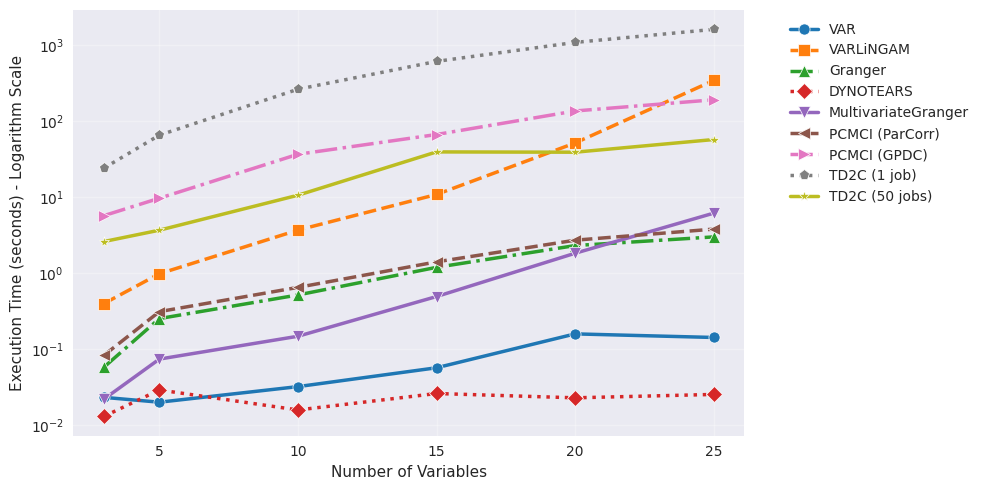

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('seaborn-v0_8')

df = results_df

# Define distinct colors and markers for each method
methods = df['method'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-']

# Create style mapping
style_map = {}
for i, method in enumerate(methods):
    style_map[method] = {
        'color': colors[i % len(colors)],
        'marker': markers[i % len(markers)],
        'linestyle': linestyles[i % len(linestyles)]
    }

# Plot 1: Line plot showing scaling with number of variables
plt.figure(figsize=(10,5))
for method in methods:
    method_data = df[df['method'] == method]
    style = style_map[method]
    plt.plot(method_data['n_variables'], method_data['execution_time'], 
             marker=style['marker'], linewidth=2.5, markersize=8, 
             label=method, color=style['color'], linestyle=style['linestyle'],
             markeredgecolor='white', markeredgewidth=0.5)

plt.xlabel('Number of Variables')
plt.ylabel('Execution Time (seconds) - Logarithm Scale')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('benchmark_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

# # Plot 2: Bar plot for comparison at 10 variables
# plt.figure(figsize=(12, 8))
# df_10vars = df[df['n_variables'] == 10].sort_values('execution_time')
# # Use distinct colors for bars
# bar_colors = [style_map[method]['color'] for method in df_10vars['method']]
# bars = plt.bar(range(len(df_10vars)), df_10vars['execution_time'], 
#                color=bar_colors, alpha=0.8, edgecolor='white', linewidth=1)
# plt.xlabel('Methods')
# plt.ylabel('Execution Time (seconds)')
# plt.title('Method Comparison (10 Variables)')
# plt.xticks(range(len(df_10vars)), df_10vars['method'], rotation=45, ha='right')
# plt.yscale('log')
# plt.grid(True, alpha=0.3)

# # Add value labels on bars
# for i, bar in enumerate(bars):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2., height,
#              f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# plt.tight_layout()
# plt.savefig('benchmark_10vars_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Plot 3: Heatmap showing execution times
# plt.figure(figsize=(12, 10))
# pivot_df = df.pivot(index='method', columns='n_variables', values='execution_time')
# # Use a more vibrant colormap with better contrast
# sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='plasma', 
#             norm=LogNorm(), cbar_kws={'label': 'Execution Time (seconds)'},
#             linewidths=0.5, linecolor='white')
# plt.title('Execution Time Heatmap (Log Scale)')
# plt.xlabel('Number of Variables')
# plt.ylabel('Method')
# plt.tight_layout()
# plt.savefig('benchmark_heatmap.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Plot 4: Box plot showing distribution of execution times by method
# plt.figure(figsize=(12, 10))
# df_boxplot = df.copy()
# df_boxplot['log_execution_time'] = np.log10(df_boxplot['execution_time'])
# # Create custom color palette for box plot
# box_colors = [style_map[method]['color'] for method in df_boxplot['method'].unique()]
# sns.boxplot(data=df_boxplot, y='method', x='log_execution_time', 
#             palette=box_colors)
# plt.xlabel('Log₁₀(Execution Time)')
# plt.ylabel('Method')
# plt.title('Distribution of Execution Times by Method')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig('benchmark_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Additional analysis: Create a summary table
# print("Summary Statistics:")
# print("=" * 50)
# summary_stats = df.groupby('method')['execution_time'].agg(['mean', 'std', 'min', 'max'])
# summary_stats = summary_stats.round(4)
# print(summary_stats)

# # Show fastest and slowest methods
# print("\nFastest methods (average execution time):")
# print(summary_stats.sort_values('mean').head(3))

# print("\nSlowest methods (average execution time):")
# print(summary_stats.sort_values('mean').tail(3))

# # Scaling analysis
# print("\nScaling Analysis (execution time ratio from 3 to 25 variables):")
# print("=" * 60)
# for method in df['method'].unique():
#     method_data = df[df['method'] == method]
#     time_3vars = method_data[method_data['n_variables'] == 3]['execution_time'].values[0]
#     time_25vars = method_data[method_data['n_variables'] == 25]['execution_time'].values[0]
#     scaling_factor = time_25vars / time_3vars
#     print(f"{method:20s}: {scaling_factor:8.1f}x slower")

# # Bonus: Create a plot focusing on the fastest methods
# plt.figure(figsize=(12, 8))
# fast_methods = ['VAR', 'DYNOTEARS', 'Granger', 'MultivariateGranger', 'PCMCI (ParCorr)']
# for method in fast_methods:
#     method_data = df[df['method'] == method]
#     style = style_map[method]
#     plt.plot(method_data['n_variables'], method_data['execution_time'], 
#              marker=style['marker'], linewidth=3, markersize=10, label=method,
#              color=style['color'], linestyle=style['linestyle'],
#              markeredgecolor='white', markeredgewidth=0.5)

# plt.xlabel('Number of Variables')
# plt.ylabel('Execution Time (seconds)')
# plt.title('Fastest Causal Discovery Methods Comparison')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig('benchmark_fast_methods.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\nAll plots saved:")
# print("- benchmark_scaling.png")
# print("- benchmark_10vars_comparison.png") 
# print("- benchmark_heatmap.png")
# print("- benchmark_distribution.png")
# print("- benchmark_fast_methods.png")